## Exploring Healthcare Insights and Outcomes in Critical Care Patients Data
### Predictive Modeling (Work in progress)
##### Project Author: Bruno Ferreira    
##### Date: March-April 2024

In this notebook, we will focus on predicting in-hospital mortality using the `mimic_iv` dataframe, created using patient data out of Beth Israel Deaconess Medical Center's electronic health records (EHRs) (Sample of 100 patients admitted to emergency departments and intensive care units).

##### Features Description

- `subject_id`: Unique identifier for each patient.
- `race`: The patient's race/ethnicity.
- `last_stay`: Duration (in days) of the last hospital stay.
- `avg_stay`: Average duration (in days) of hospital stays.
- `total_admissions`: Total number of hospital admissions for the patient.
- `gender`: Gender of the patient (FEMALE = 0; MALE = 1).
- `age`: Age of the patient at the time of data collection.
- `infectious_diseases`: Binary indicator (0 or 1) for diagnosis of infectious diseases (1 = patient has or had such disease, valid for all health conditions)
- `cancer`: Binary indicator (0 or 1) for diagnosis of cancer.
- `endocrine_disorders`: Binary indicator (0 or 1) for diagnosis of endocrine disorders.
- `blood_disorders`: Binary indicator (0 or 1) for diagnosis of blood disorders.
- `mental_disorders`: Binary indicator (0 or 1) for diagnosis of mental disorders.
- `nervous_disorders`: Binary indicator (0 or 1) for diagnosis of nervous system disorders.
- `cardiovascular_disorders`: Binary indicator (0 or 1) for diagnosis of cardiovascular disorders.
- `respiratory_disorders`: Binary indicator (0 or 1) for diagnosis of respiratory disorders.
- `digestive_disorders`: Binary indicator (0 or 1) for diagnosis of digestive disorders.
- `genitourinary_disorders`: Binary indicator (0 or 1) for diagnosis of genitourinary disorders.
- `pregnancy_complications`: Binary indicator (0 or 1) for diagnosis of pregnancy complications.
- `skin_disorders`: Binary indicator (0 or 1) for diagnosis of skin disorders.
- `musculoskeletal_disorders`: Binary indicator (0 or 1) for diagnosis of musculoskeletal disorders.
- `injuries_&_poisonings`: Binary indicator (0 or 1) for diagnosis of injuries or poisonings.
- `total_diagnoses`: Total number of diagnosed conditions.
- `procedures_count`: Number of medical procedures undergone.
- `prescriptions_count`: Number of prescriptions given.
- `bmi_index`: Body Mass Index (BMI) of the patient.
- `systolic_bp`: Systolic blood pressure reading.
- `diastolic_bp`: Diastolic blood pressure reading.
- `abnorm_labresults_ratio`: Ratio of abnormal lab results to total lab results.
- `1yr_death`: Binary indicator (0 or 1) for in-hospital death or within 1 year of last hospital discharge (0 if alive, 1 if deceased).
- `deceased`: Binary indicator (0 or 1) for in-hospital death only (0 if alive, 1 if deceased).

#### Identifying Key Features for Predicting Mortality

We now need to identify key features that are highly correlated with `deceased` target variable and are likely to be strong predictors of mortality. These features will be used in the construction of our predictive model.


##### Loading our previously cleaned and processed main data frame (see "Data Cleaning & Preparation Notebook" on GitHub):

In [116]:
# Loading dataframe with one-hot encoded categorical variables
file_path = r'C:\Users\bruno\Desktop\mimic\mimic_iv.csv' 
mimic = pd.read_csv(file_path) 
mimic.head(1)

,subject_id,last_stay,avg_stay,total_admissions,age,total_diagnoses,blood_disorders,cancer,cardiovascular_disorders,digestive_disorders,...,deceased,race_BLACK,race_HISPANIC,race_OTHER,race_WHITE,gender_F,gender_M,admission_type_EMERGENCY,admission_type_OBSERVATION,admission_type_PLANNED
0,10000032,1.8,1.4,4,52,32,0,0,0,1,...,0,0,0,0,1,1,0,1,0,0


#### Finding potential predictors with correlation higher than 0.15 with our target variable

In [305]:
columns_to_exclude = ['subject_id', '1yr_death', 'last_stay']  # Columns to exclude from correlation analysis

relevant_columns = [col for col in mimic.columns if col not in columns_to_exclude]

correlation_with_deceased = mimic[relevant_columns].corr()['deceased']  # Calculate correlation with our 'deceased' target variable
sorted_correlations = correlation_with_deceased.abs().sort_values(ascending=False)

top_correlated_variables = sorted_correlations.drop('deceased')  # Display ordered list of top correlated variables with 'deceased'

# Filter top correlated variables based on correlation threshold (e.g., >= 0.15)
correlated_variables_above_threshold = top_correlated_variables[top_correlated_variables >= 0.15]

# Print formatted correlation values for variables above the threshold
print("Correlation of predictor independent variables with our target 'deceased' (>= 0.15):")
for variable, correlation in correlated_variables_above_threshold.items():
    formatted_correlation = f"{correlation:.2f}"  # Format correlation coefficient to two decimal places
    print(f"{variable}: {formatted_correlation}")

Correlation of predictor independent variables with our target 'deceased' (>= 0.15):
abnorm_labresults_ratio: 0.38
blood_disorders: 0.31
injuries_&_poisonings: 0.27
avg_stay: 0.23
prescriptions_count: 0.21
gender_M: 0.20
gender_F: 0.20
admission_type_PLANNED: 0.19
genitourinary_disorders: 0.19
age: 0.18
admission_type_EMERGENCY: 0.16
cancer: 0.16
race_OTHER: 0.15
musculoskeletal_disorders: 0.15


#### We also want to discard predictors highly correlated with each other to avoid multicolinearity

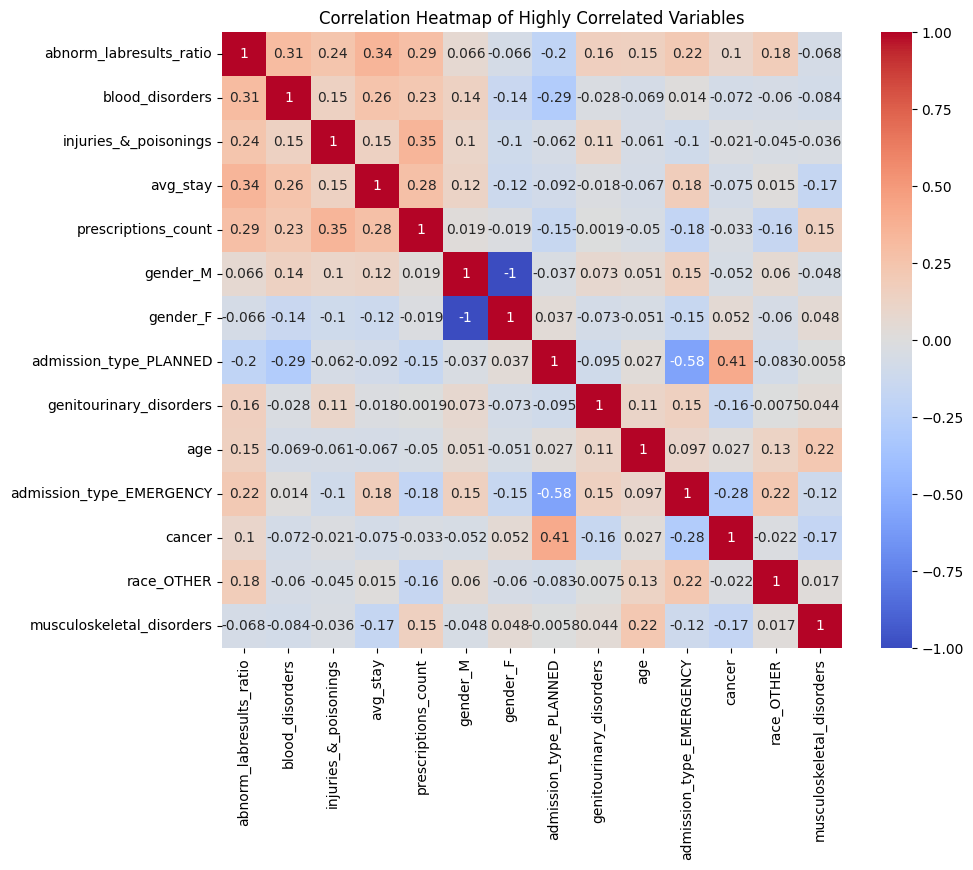

In [306]:
#HEATMAP OF PREDICTORS CORRELATIONS
# Select only the columns of interest based on the highly correlated variables
columns_of_interest = correlated_variables_above_threshold.index.tolist()
data_subset = mimic[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = data_subset.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Highly Correlated Variables")
plt.show()

- We should remove one of the 'gender' and 'admission_type' variables because they're highly correlated. Also 'race_OTHER' isn't a good predictor because it's too vague.

#### Narrowing down number of features (Logistic Lasso regression)
With such a small dataset, too many variables may lead the model to overfit. To prevent that, we'll narrow down even further the number of features for training the model. We can use logistic regression with lasso (l1) regularization, where the importance of each feature can be assessed by examining  the magnitude (non-zero) of their coefficients.

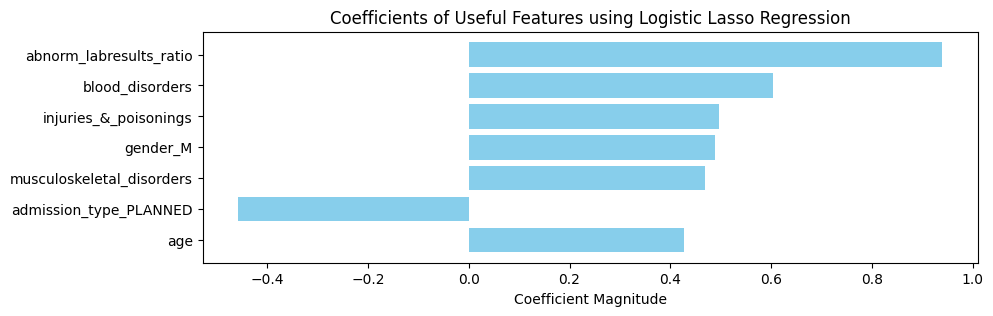

In [338]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
# Assuming 'mimic' is your dataframe containing selected_features and 'deceased'
selected_features = ['abnorm_labresults_ratio','blood_disorders','injuries_&_poisonings','gender_M',
                     'age','admission_type_PLANNED','musculoskeletal_disorders']

# Assuming 'mimic' dataframe contains the selected features and the target variable 'deceased'
X = mimic[selected_features]
y = mimic['deceased']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize logistic regression model with L1 regularization (Lasso), that will select only the useful features (non-zero coefficient)
logreg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42) # 'liblinear' is compatible with l1 and ideal for small dataset

# Use SelectFromModel to automatically select features based on L1 regularization and fit
selector = SelectFromModel(logreg)
X_selected = selector.fit_transform(X_scaled, y)

# Get the selected feature names
selected_features = np.array(selected_features)[selector.get_support()]

# Fit logistic regression model using the selected features
logreg.fit(X_selected, y)

# Get the coefficients of the logistic regression model
coefficients = logreg.coef_[0]

# Sort features by absolute coefficient values
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_features = selected_features[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 3))
plt.barh(sorted_features, sorted_coefficients, color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Coefficients of Useful Features using Logistic Lasso Regression')
plt.gca().invert_yaxis()  # Invert y-axis to display highest magnitude at the top
plt.show()

#### We can also use grid search to find the best hyperparameters to our model

In [339]:
from sklearn.model_selection import GridSearchCV

# Splitting data into features (X) and target (y)
X = mimic[sorted_features]  # Features (independent variables)
y = mimic['deceased']  # Target (dependent variable)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set up parameters for grid search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter (smaller values indicate stronger regularization)
              'penalty': ['l1','l2']} # Our features are already selected, no need to strictly use 'l1'

# Instantiate logistic regression model
logreg_model = LogisticRegression(random_state=42, solver='liblinear')

# Perform grid search using cross-validation (e.g., 5-fold cross-validation)
grid_search = GridSearchCV(logreg_model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_scaled, y)

# Print the best parameters found by grid search
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 0.001, 'penalty': 'l2'}


#### Constructing and evaluating our model

In [340]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Splitting data into features (X) and target (y)
X = mimic[sorted_features]  # Features (independent variables)
y = mimic['deceased']  # Target (dependent variable)

# Standardizing the features (recommended for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize logistic regression model with best hyperparameters
logreg_model = LogisticRegression(C=0.001, solver='liblinear', penalty='l2', random_state=42)

# Define K-fold cross-validation
k = 5  # Number of folds
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)

# Define scoring metrics
scoring = {'accuracy': 'accuracy',
           'roc_auc': 'roc_auc',
           'f1': 'f1'}

# Perform cross-validation
results = cross_validate(logreg_model, X_scaled, y, cv=cv, scoring=scoring)

# Extract and print average scores
print(f"Average Accuracy: {np.mean(results['test_accuracy']):.2f}")
print(f"Average ROC-AUC Score: {np.mean(results['test_roc_auc']):.2f}")
print(f"Average F1-Score: {np.mean(results['test_f1']):.2f}")

# Optionally, print detailed evaluation metrics for each fold
for i, (train_index, test_index) in enumerate(cv.split(X_scaled, y)):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    logreg_model.fit(X_train, y_train)
    y_pred = logreg_model.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, logreg_model.predict_proba(X_test)[:, 1])
    
    print(f"\nFold {i+1}:")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Classification Report:\n{class_report}")
    print(f"ROC-AUC Score: {roc_auc:.2f}")

Average Accuracy: 0.91
Average ROC-AUC Score: 0.89
Average F1-Score: 0.69

Fold 1:
Confusion Matrix:
[[16  1]
 [ 1  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.67      0.67      0.67         3

    accuracy                           0.90        20
   macro avg       0.80      0.80      0.80        20
weighted avg       0.90      0.90      0.90        20

ROC-AUC Score: 0.94

Fold 2:
Confusion Matrix:
[[15  2]
 [ 1  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.50      0.67      0.57         3

    accuracy                           0.85        20
   macro avg       0.72      0.77      0.74        20
weighted avg       0.87      0.85      0.86        20

ROC-AUC Score: 0.82

Fold 3:
Confusion Matrix:
[[17  0]
 [ 0  3]]
Classification Report:
              precision  

- The model's performance across five-fold cross-validation shows consistent accuracy, with an average of 91%, and a respectable average ROC-AUC score of 0.89, indicating good discrimination between classes. However, there are notable disparities in precision and recall between the two classes (0 and 1). While class 0 (the majority class) consistently demonstrates high precision and recall, class 1 (the minority class) exhibits lower precision and recall. A low recall for the positive class (indicating patients who do not survive) implies that the model is struggling to identify a significant number of actual instances where patients do not survive (i.e., true positives). This means that the model may be overlooking patients who are at a higher risk of mortality, leading to potential missed opportunities for timely intervention or appropriate allocation of resources.

- Additionally, our average F1-score is of 0.69, which is still a decent value despite low recall. There seems to be some variability across the 5 folds evaluation metrics, suggesting some overfitting probably due to the small dataset size. The best way to improve overall performance, particularly for class 1, should be to increase the size of the dataset, using the full MIMIC-IV dataset, which is more difficult to access. With a larger dataset we could also safely add more predictor features without fearing overfitting and improving model metrics.